## Non-exonic windows, with Gnocchi and various features (e.g. GC content), and enhancer-overlap status 

In [1]:
from get_windows import get_windows_with_GC_content_and_cpg_islands 

WINDOWS = get_windows_with_GC_content_and_cpg_islands()
WINDOWS 

,chrom,start,end,gnocchi,N_observed,window overlaps enhancer,window overlaps merged_exon,B,paternal_recombination_rate,maternal_recombination_rate,...,B1_M3starHMT6.EUR,Bmean_M3starHMT6.EUR,lambda_M3starHMT6.EUR,GC_content_1000bp,GC_content_10000bp,GC_content_100000bp,GC_content_1000000bp,cpg_island_overlap,window_overlaps_cpg_island,N_mean_null_gnocchi
0,chr1,1432000,1433000,4.299894,259,True,False,0.653,0.039046,0.025852,...,0.513191,0.105518,2.585568,0.661339,0.641836,0.565094,0.577534,NaN,False,338.059552
1,chr1,1451000,1452000,0.666316,291,False,False,0.652,0.039046,0.025852,...,0.513191,0.105518,2.585568,0.556444,0.552845,0.572894,0.575506,NaN,False,302.590657
2,chr1,1453000,1454000,0.828398,256,False,False,0.651,0.039046,0.025852,...,0.513191,0.105518,2.585568,0.537463,0.561944,0.572564,0.575129,NaN,False,269.601925
3,chr1,1458000,1459000,-0.086128,272,False,False,0.651,0.039046,0.025852,...,0.513191,0.105518,2.585568,0.532468,0.596740,0.570774,0.575225,NaN,False,270.583243
4,chr1,1463000,1464000,2.948188,191,True,False,0.651,0.039046,0.025852,...,0.513191,0.105518,2.585568,0.540460,0.568843,0.576514,0.574420,NaN,False,236.321790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019146,chr9,137262000,137263000,-2.396149,302,True,False,0.536,0.057053,0.063434,...,3.636507,0.219258,2.281162,0.500499,0.542646,0.611944,0.568316,45.0,True,263.131293
1019147,chr9,137268000,137269000,3.640544,212,True,False,0.536,0.057053,0.063434,...,3.636507,0.219258,2.281162,0.552448,0.589941,0.613074,0.567839,NaN,False,272.046527
1019148,chr9,137269000,137270000,5.276351,209,True,False,0.536,0.057053,0.063434,...,3.636507,0.219258,2.281162,0.519481,0.585042,0.613494,0.567623,NaN,False,300.458958
1019149,chr9,137275000,137276000,2.687348,290,True,False,0.536,1.564889,0.024254,...,3.636507,0.219258,2.281162,0.603397,0.639236,0.610484,0.567380,NaN,False,339.517045


## Gnocchi is biased as a function of GC-content, even for windows that are not constrained, but average gnocchi is still different for windows that are and are not constrained

In [2]:
import matplotlib.pyplot as plt 
plt.rcParams.update({
    'font.size': 20,
    'font.family': 'arial',
    'figure.figsize': (12, 6)
})

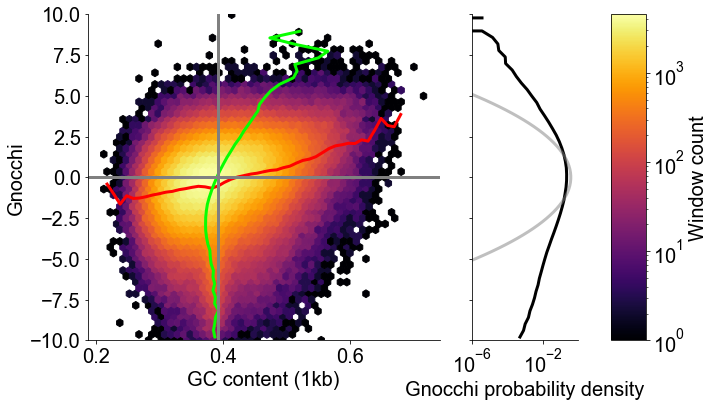

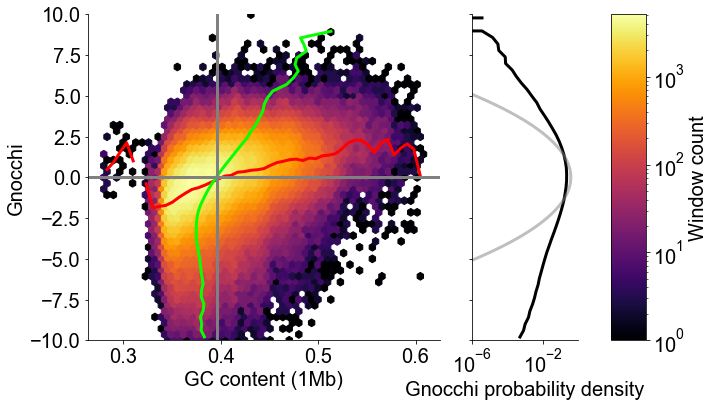

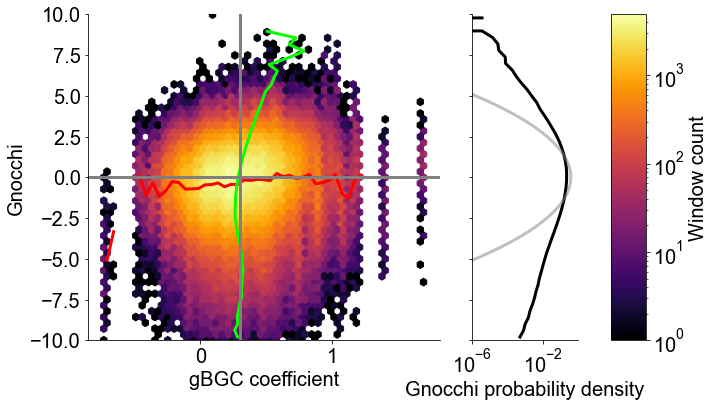

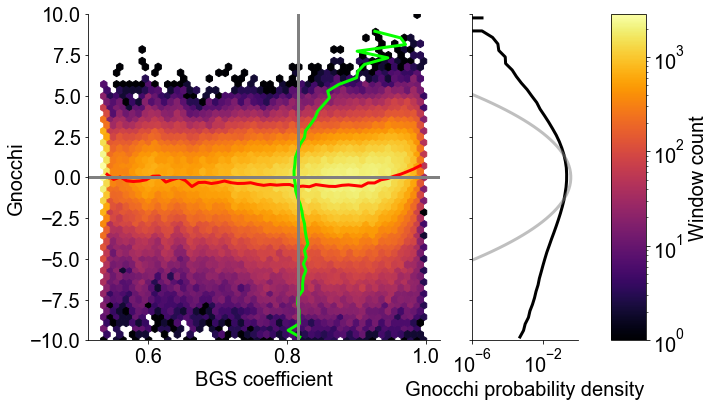

In [3]:
from scipy import stats
import numpy as np
from matplotlib.colors import LogNorm

from util import length_to_string

def window_count_heat_map_gnocchi(df, x, xlabel, window_overlaps_enhancer, filename=None, cmap='inferno', min_windows=1):
    df = df[df['window overlaps enhancer'] == window_overlaps_enhancer]

    # Create a new figure and a grid of subplots
    fig, (ax_joint, ax_marginal, ax_colorbar) = plt.subplots(1, 3, figsize=(10, 6), gridspec_kw={'width_ratios': [5, 1.5, 0.5]})

    # Make ax_marginal share its y-axis with ax_joint
    ax_joint.get_shared_y_axes().join(ax_joint, ax_marginal)

    for side in ['top', 'right']:
        ax_joint.spines[side].set_visible(False)
        ax_marginal.spines[side].set_visible(False)

    # set ylim on ax_joint 
    ax_joint.set_ylim(-10, 10)

    # Create the hexbin plot in the joint axes
    hb = ax_joint.hexbin(
        df[x], 
        df['gnocchi'], 
        gridsize=50, 
        cmap=cmap, 
        norm=LogNorm(),  # Apply LogNorm here
        mincnt=min_windows,
    )

    # compute the average gnocchi value for each bin of x 
    x_edges = np.linspace(df[x].min(), df[x].max(), 50)
    x_mids = (x_edges[:-1] + x_edges[1:]) / 2
    y_values = []
    for i in range(1, len(x_edges)):
        mask = (df[x] >= x_edges[i-1]) & (df[x] < x_edges[i])
        y_values.append(df.loc[mask, 'gnocchi'].mean())
    y_values = np.array(y_values)

    # Plot the average gnocchi value for each bin of x
    ax_joint.plot(x_mids, y_values, color='red', lw=3)

    # compute the average x value for each bin of gnocchi 
    y_edges = np.linspace(df['gnocchi'].min(), df['gnocchi'].max(), 50)
    y_mids = (y_edges[:-1] + y_edges[1:]) / 2
    x_values = []
    for i in range(1, len(y_edges)):
        mask = (df['gnocchi'] >= y_edges[i-1]) & (df['gnocchi'] < y_edges[i])
        x_values.append(df.loc[mask, x].mean())
    x_values = np.array(x_values)

    # Plot the average x value for each bin of gnocchi
    ax_joint.plot(x_values, y_mids, color=(8/255, 255/255, 0/255), lw=3)

    # draw a vertical line at the mean of x 
    ax_joint.axvline(df[x].mean(), color='grey', lw=3)

    # draw a horizontal line at y = 0 
    ax_joint.axhline(0, color='grey', lw=3)

    # Compute a histogram and normalize it to be a density
    x_values, y_edges = np.histogram(df['gnocchi'], bins=50, density=True)
    y_mids = 0.5*(y_edges[1:] + y_edges[:-1])

    # Plot the density as a line plot in the marginal y axes
    # Note: we don't want to plot as bars on a log axis ...
    # ... because the bars create wide invisible objects in the pdf ...
    # ... that only become apparent upon import to adobe illustrator
    ax_marginal.plot(x_values, y_mids, marker='', color='black', lw=3)

    # Remove the y-tick labels from the marginal histogram
    ax_marginal.tick_params(axis='y', which='both', labelleft=False)

    # Set the x-axis limits on the marginal y axes
    ax_marginal.set_xlim(1e-6, 1)  

    # Set the x-axis scale on the marginal y axes to log
    ax_marginal.set_xscale('log')

    ax_marginal.set_xlabel('Gnocchi probability density')

    # Plot a standard normal pdf on the marginal y axes
    y_values = np.linspace(df['gnocchi'].min(), df['gnocchi'].max(), 100)
    ax_marginal.plot(stats.norm.pdf(y_values), y_values, color='grey', alpha=0.5, lw=3)

    ax_joint.set_xlabel(xlabel)
    ax_joint.set_ylabel('Gnocchi')

    # Add a colorbar for the hexbin plot
    cbar = plt.colorbar(hb, cax=ax_colorbar)

    # Add a label to the colorbar
    cbar.set_label('Window count')

    if filename:
      fig.savefig(filename, dpi=300, bbox_inches='tight')

def window_count_heat_map_gnocchi_all_features(df, window_overlaps_enhancer):     
  GC_WINDOW_SIZE = 1000
  window_count_heat_map_gnocchi(
    df, 
    x=f'GC_content_{GC_WINDOW_SIZE}bp', 
    xlabel=f'GC content ({length_to_string(GC_WINDOW_SIZE)})', 
    window_overlaps_enhancer=window_overlaps_enhancer
  )

  GC_WINDOW_SIZE = 1000000
  window_count_heat_map_gnocchi(
    df, 
    x=f'GC_content_{GC_WINDOW_SIZE}bp', 
    xlabel=f'GC content ({length_to_string(GC_WINDOW_SIZE)})', 
    window_overlaps_enhancer=window_overlaps_enhancer
  )

  window_count_heat_map_gnocchi(
    df, 
    x='B_M1star.EUR',
    xlabel='gBGC coefficient',
    window_overlaps_enhancer=window_overlaps_enhancer
  )

  window_count_heat_map_gnocchi(
    df, 
    x='B',
    xlabel='BGS coefficient',
    window_overlaps_enhancer=window_overlaps_enhancer
  )

window_count_heat_map_gnocchi_all_features(WINDOWS, window_overlaps_enhancer=False)

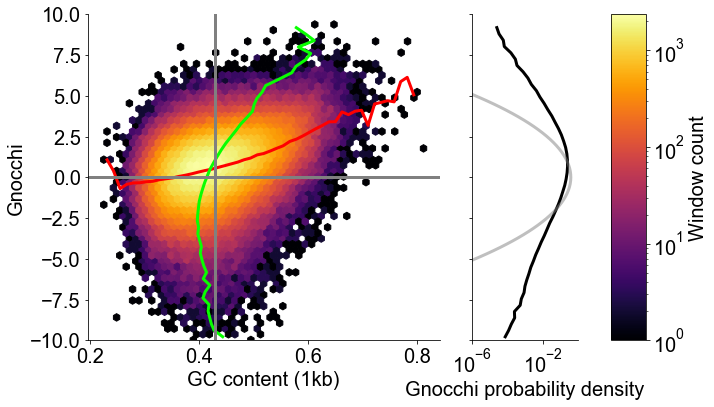

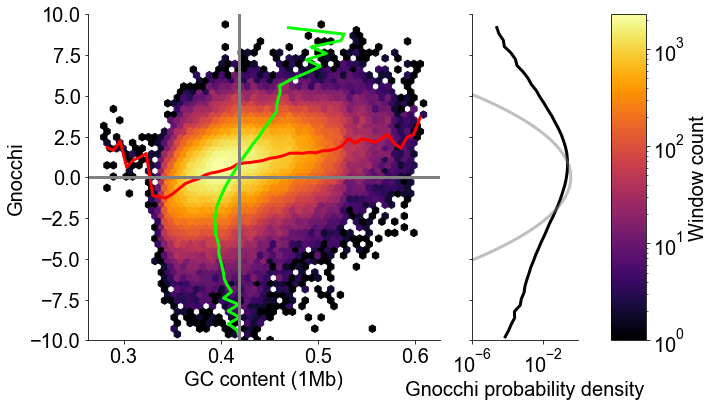

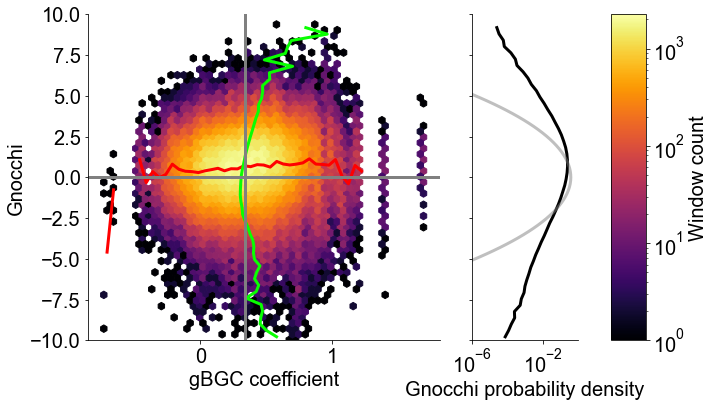

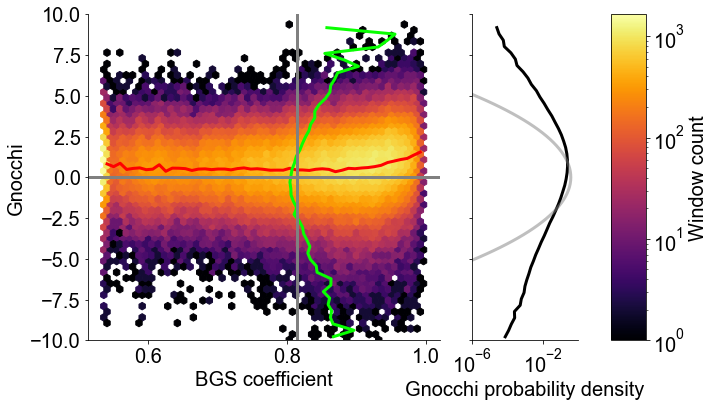

In [4]:
window_count_heat_map_gnocchi_all_features(WINDOWS, window_overlaps_enhancer=True)

## Fraction of windows that overlap enhancers 

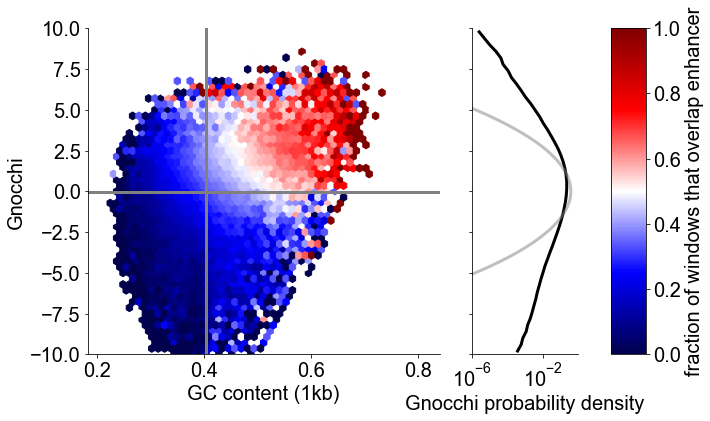

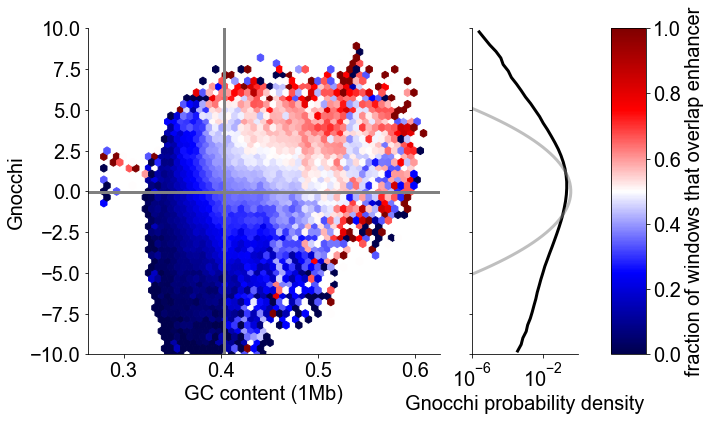

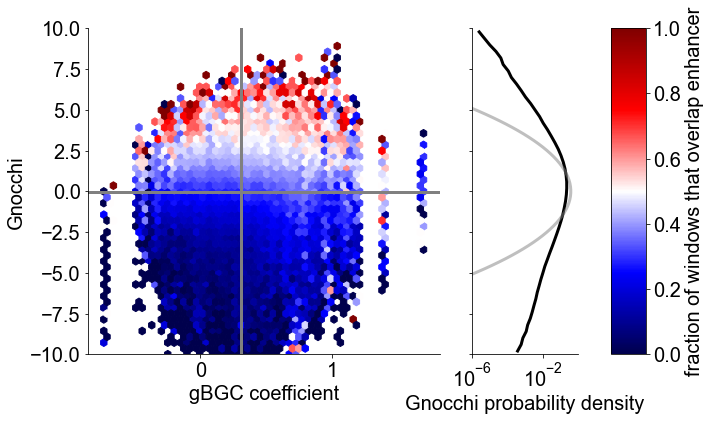

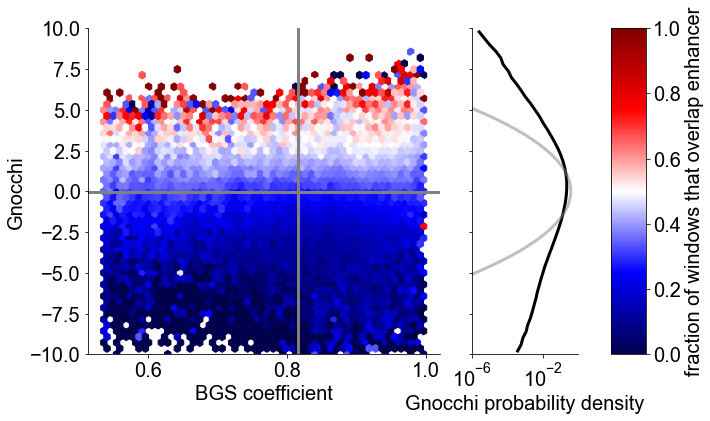

In [5]:
from matplotlib.colors import TwoSlopeNorm
import matplotlib.cm as cm

def enhancer_fraction_heat_map_gnocchi(df, x, xlabel, filename=None, cmap='coolwarm', min_windows=1):
    # Create a new figure and a grid of subplots
    fig, (ax_joint, ax_marginal, ax_colorbar) = plt.subplots(1, 3, figsize=(10, 6), gridspec_kw={'width_ratios': [5, 1.5, 0.5]})

    # Make ax_marginal share its y-axis with ax_joint
    ax_joint.get_shared_y_axes().join(ax_joint, ax_marginal)

    for side in ['top', 'right']:
        ax_joint.spines[side].set_visible(False)
        ax_marginal.spines[side].set_visible(False)

    # set ylim on ax_joint 
    ax_joint.set_ylim(-10, 10)

    # Create a diverging colormap
    cmap = cm.get_cmap('seismic')  # Use cm.get_cmap instead of plt.get_cmap
    divnorm = TwoSlopeNorm(vmin=0, vcenter=0.5, vmax=1)

    # Create the hexbin plot in the joint axes
    hb = ax_joint.hexbin(
        df[x], 
        df['gnocchi'], 
        C=df['window overlaps enhancer'],
        reduce_C_function=np.mean,
        gridsize=50, 
        cmap=cmap,
        norm=divnorm,
        mincnt=min_windows,
    )

    # draw a vertical line at the mean of x 
    ax_joint.axvline(df[x].mean(), color='grey', lw=3)

    # draw a horizontal line at the mean of y  
    ax_joint.axhline(df['gnocchi'].mean(), color='grey', lw=3)

    # Compute a histogram and normalize it to be a density
    x_values, y_edges = np.histogram(df['gnocchi'], bins=50, density=True)
    y_mids = 0.5*(y_edges[1:] + y_edges[:-1])

    # Plot the density as a line plot in the marginal y axes
    # Note: we don't want to plot as bars on a log axis ...
    # ... because the bars create wide invisible objects in the pdf ...
    # ... that only become apparent upon import to adobe illustrator
    ax_marginal.plot(x_values, y_mids, marker='', color='black', lw=3)

    # Remove the y-tick labels from the marginal histogram
    ax_marginal.tick_params(axis='y', which='both', labelleft=False)

    # Set the x-axis limits on the marginal y axes
    ax_marginal.set_xlim(1e-6, 1)  

    # Set the x-axis scale on the marginal y axes to log
    ax_marginal.set_xscale('log')

    ax_marginal.set_xlabel('Gnocchi probability density')

    # Plot a standard normal pdf on the marginal y axes
    y_values = np.linspace(df['gnocchi'].min(), df['gnocchi'].max(), 100)
    ax_marginal.plot(stats.norm.pdf(y_values), y_values, color='grey', alpha=0.5, lw=3)

    ax_joint.set_xlabel(xlabel)
    ax_joint.set_ylabel('Gnocchi')

    # Add a colorbar for the hexbin plot
    cbar = plt.colorbar(hb, cax=ax_colorbar)

    # Add a label to the colorbar
    cbar.set_label('fraction of windows that overlap enhancer')

    if filename:
      fig.savefig(filename, dpi=300, bbox_inches='tight')
      
GC_WINDOW_SIZE = 1000
enhancer_fraction_heat_map_gnocchi(
  WINDOWS, 
  x=f'GC_content_{GC_WINDOW_SIZE}bp', 
  xlabel=f'GC content ({length_to_string(GC_WINDOW_SIZE)})', 
)

GC_WINDOW_SIZE = 1000000
enhancer_fraction_heat_map_gnocchi(
  WINDOWS, 
  x=f'GC_content_{GC_WINDOW_SIZE}bp', 
  xlabel=f'GC content ({length_to_string(GC_WINDOW_SIZE)})', 
)

enhancer_fraction_heat_map_gnocchi(
  WINDOWS, 
  x='B_M1star.EUR',
  xlabel='gBGC coefficient'
)

enhancer_fraction_heat_map_gnocchi(
  WINDOWS, 
  x='B',
  xlabel='BGS coefficient'
)

conditioning on B_M1star.EUR in [0.23312384366208225, 0.39194030697055426]
conditioning on B in [0.7791188082310888, 0.8516373073984892]
conditioning on GC_content_1000bp in [0.3855522819856123, 0.4223190176726326]
conditioning on B in [0.7791188082310888, 0.8516373073984892]
conditioning on GC_content_1000bp in [0.3855522819856123, 0.4223190176726326]
conditioning on B_M1star.EUR in [0.23312384366208225, 0.39194030697055426]


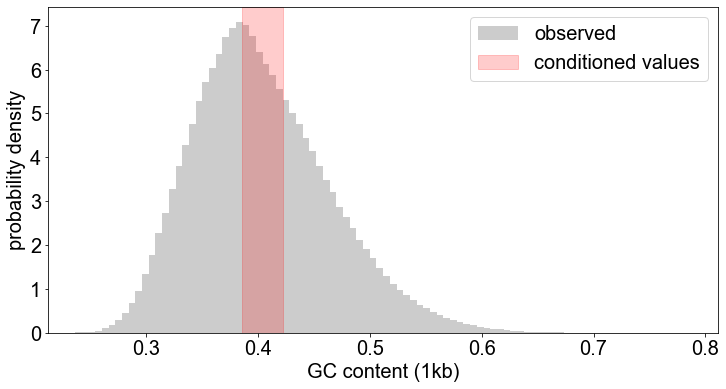

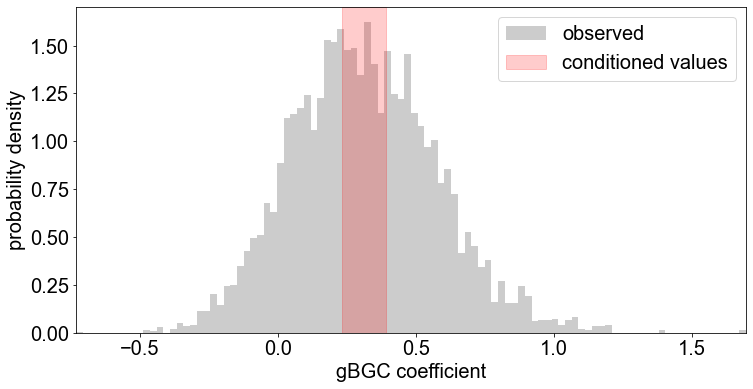

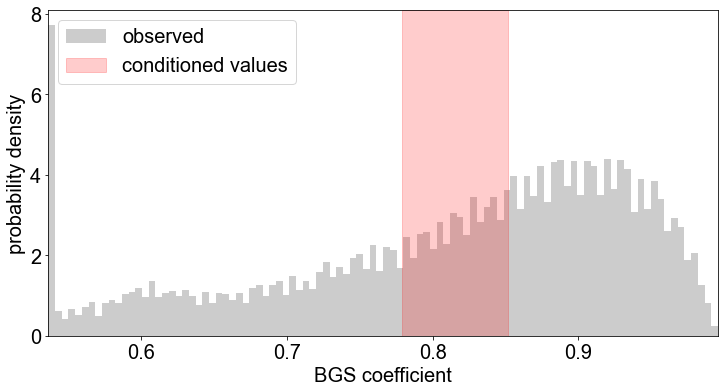

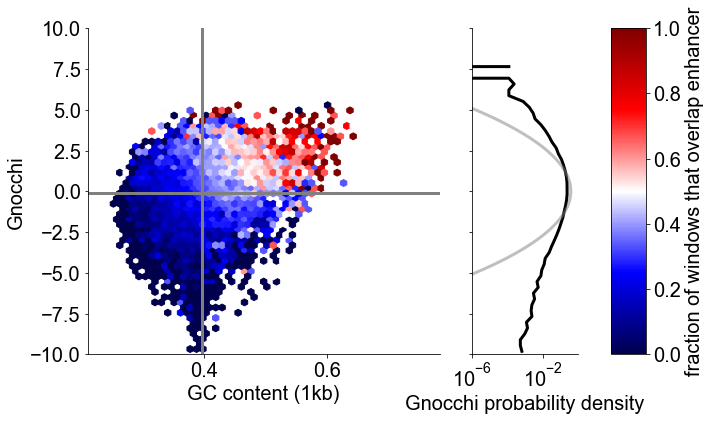

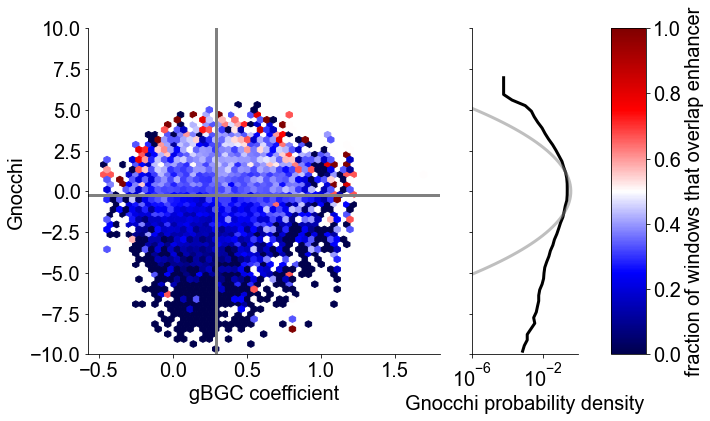

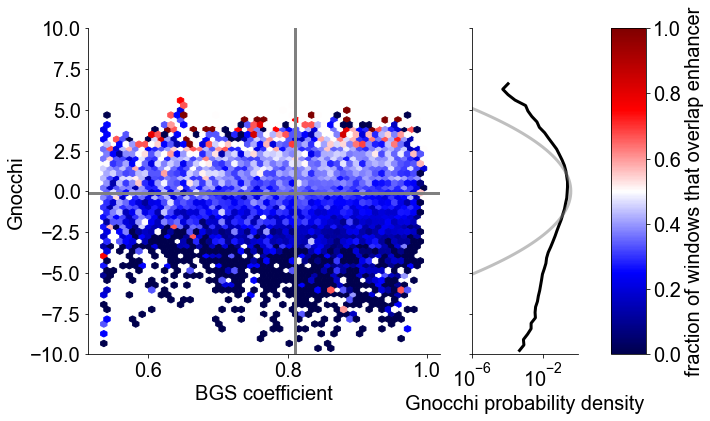

In [6]:
from util import (
  compute_limits, 
  slice_feature_space, 
  plot_feature_distribution
)

def get_mean_factor(gc_window_size): 
  if gc_window_size == 1000: 
    return 1
  elif gc_window_size == 1000000:
    return 0.975
  else:
    raise ValueError(f'invalid GC window size: {gc_window_size}')
                     
def get_std_factor(gc_window_size): 
  if gc_window_size == 1000: 
    return 0.3
  elif gc_window_size == 1000000:
    return 0.5
  else:
    raise ValueError(f'invalid GC window size: {gc_window_size}')

def enhancer_fraction_heat_map_gnocchi_all(df, gc_window_size):
  features_and_lims_and_labels = [
    (
      f'GC_content_{gc_window_size}bp', 
      compute_limits(
        df, 
        f'GC_content_{gc_window_size}bp', 
        mean_factor=get_mean_factor(gc_window_size), 
        std_factor=get_std_factor(gc_window_size)
      ), 
      f'GC content ({length_to_string(gc_window_size)})'
    ),
    (
      'B_M1star.EUR', 
      compute_limits(
        df, 
        'B_M1star.EUR', 
        mean_factor=1, 
        std_factor=0.3
      ), 
      'gBGC coefficient'
    ),
    (
      'B', 
      compute_limits(
        df, 
        'B', 
        mean_factor=1, 
        std_factor=0.3
      ), 
      'BGS coefficient'
    )
  ]

  for feature, lim, label in features_and_lims_and_labels:
    plot_feature_distribution(df, feature, xlabel=label, lim=lim)
    
  for feature, _, label in features_and_lims_and_labels:
    conditional_features_and_lims = [
      (f, l) for f, l, _ in features_and_lims_and_labels if f != feature
    ]
    df_sliced = slice_feature_space(df, conditional_features_and_lims)    
    enhancer_fraction_heat_map_gnocchi(
      df_sliced, 
      x=feature, 
      xlabel=label, 
    )

# plot heat maps as a function of one feature, conditioned upon the other two features
enhancer_fraction_heat_map_gnocchi_all(WINDOWS, gc_window_size=1000)

conditioning on B_M1star.EUR in [0.23312384366208225, 0.39194030697055426]
conditioning on B in [0.7791188082310888, 0.8516373073984892]
conditioning on GC_content_1000000bp in [0.3727923383140851, 0.41334301026237685]
conditioning on B in [0.7791188082310888, 0.8516373073984892]
conditioning on GC_content_1000000bp in [0.3727923383140851, 0.41334301026237685]
conditioning on B_M1star.EUR in [0.23312384366208225, 0.39194030697055426]


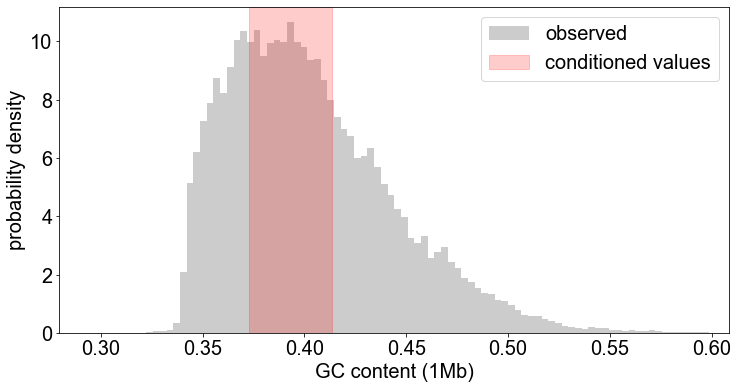

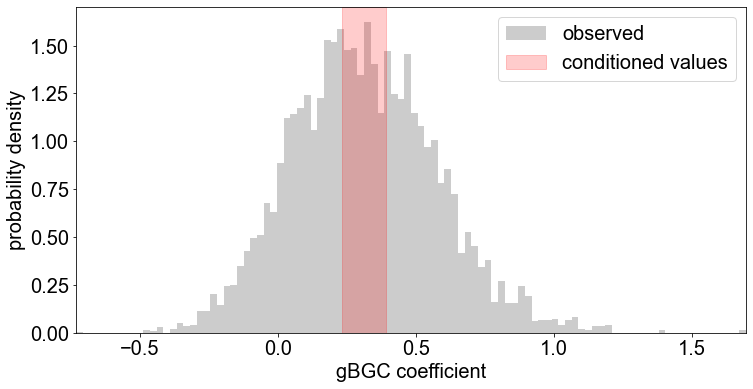

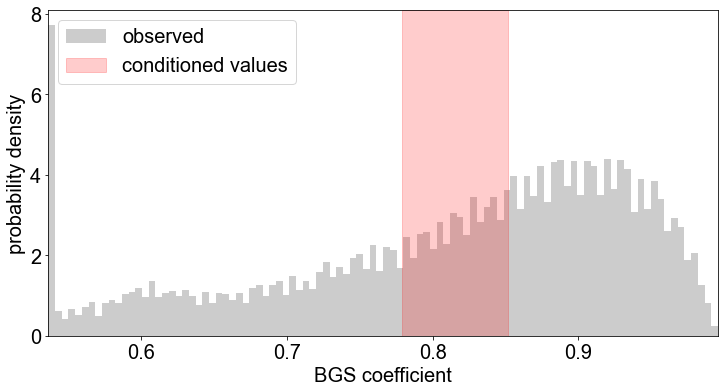

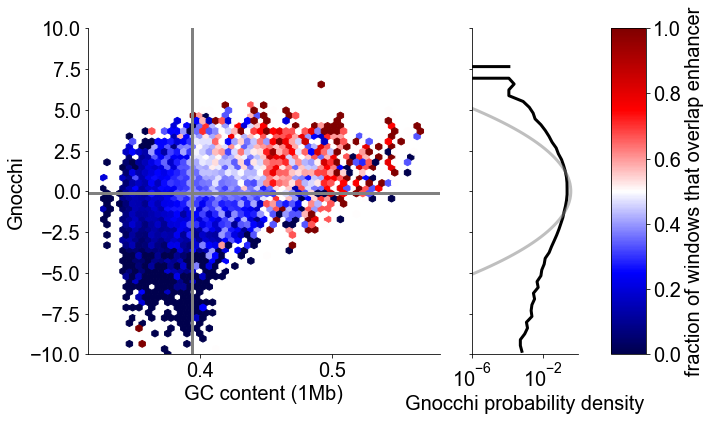

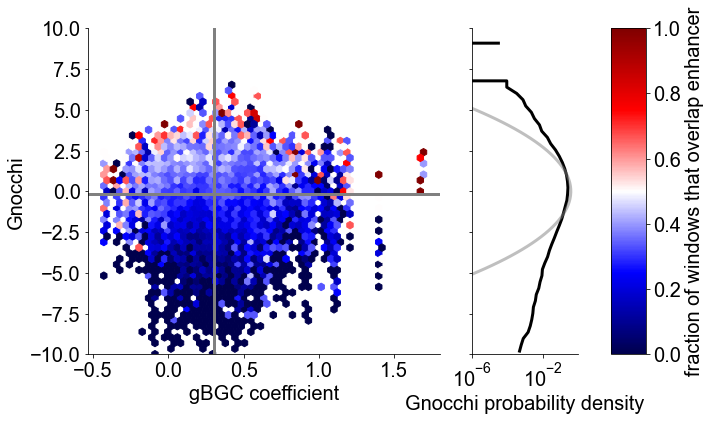

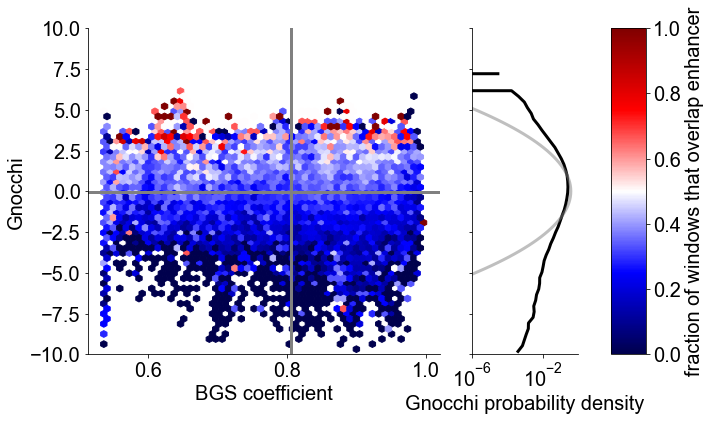

In [7]:
# plot heat maps as a function of one feature, conditioned upon the other two features
enhancer_fraction_heat_map_gnocchi_all(WINDOWS, gc_window_size=1000000)